In [21]:
import rospy
from geometry_msgs.msg import Point, Pose, Twist
from assignment_2_2022.msg import vel_pos
import assignment_2_2022.msg
from std_srvs.srv import *
import jupyros as jr
import sys
import select
from nav_msgs.msg import Odometry
import actionlib
import actionlib.msg
import time
import math
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import jupyros as jr
from sensor_msgs.msg import LaserScan
import tf
import time
from tf.transformations import quaternion_matrix 
import numpy as np
from matplotlib.animation import FuncAnimation
from actionlib_msgs.msg import GoalStatusArray
from assignment_2_2022.srv import count, countResponse

In [22]:
%matplotlib notebook
import matplotlib.pyplot as plt
import tf
from nav_msgs.msg import Odometry
from tf.transformations import quaternion_matrix
from matplotlib.animation import FuncAnimation
from actionlib_msgs.msg import GoalStatusArray
import time

start_time = time.time()
duration = 2400  # Duration in seconds
rate = 10  # Rate in Hz
interval = 1 / rate

def update_current_robot_state(msg):
    global current_state_publisher
    position = msg.pose.pose.position
    velocity = msg.twist.twist.linear
    current_state = vel_pos()
    current_state.cor_x = position.x
    current_state.cor_y = position.y
    current_state.vel_x = velocity.x
    current_state.vel_y = velocity.y
    current_state_publisher.publish(current_state)

def on_button_clicked1(button):
    global B
    B = True
    print("Goal Has been set")
    global x_des, y_des, r
    x_des = x_text.value
    y_des = y_text.value
    print(x_des)
    print(y_des)
    goal = assignment_2_2022.msg.PlanningGoal()
    goal.target_pose.pose.position.x = x_des
    goal.target_pose.pose.position.y = y_des
    client.send_goal(goal)
    rate = rospy.Rate(20)  

def cancel(button):
    global rn
    C = True
    print("Goal canceled!")
    client.cancel_goal()
    rn += 1
    print(rn) 

def plot(button):
    global r, rn, B  # Declare B as a global variable
    %matplotlib notebook
    fig, ax = plt.subplots()
    n = [r, rn]
    q = ["Reached = {}".format(r), "Not Reached = {}".format(rn)]
    plt.cla() 
    # Create or update the pie chart
    ax.pie(n, labels=q, autopct='%1.1f%%', startangle=90)
    ax.set_aspect('equal')  # Ensure the pie is circular
    plt.title("Statistics (Total = {})".format(r + rn))
    plt.show()




rospy.init_node('user_input')
current_state_publisher = rospy.Publisher("/pos_vel", vel_pos, queue_size=1)
odom_subscriber = rospy.Subscriber("/odom", Odometry, update_current_robot_state)
client = actionlib.SimpleActionClient('/reaching_goal', assignment_2_2022.msg.PlanningAction)
client.wait_for_server()

# Create text boxes for x and y position control
x_text = widgets.IntText(description='X Position:', value=0)
y_text = widgets.IntText(description='Y Position:', value=0)

# Register text change handlers
print("Choose values for x and y:")
# Display text boxes
display(x_text, y_text)

# Create a button widget
button1 = widgets.Button(description="Start")
button2 = widgets.Button(description="Cancel")
button3 = widgets.Button(description="Plot")
button4 = widgets.Button(description="Track")
# Display the button
display(button1, button2, button3)
button1.on_click(on_button_clicked1)
button2.on_click(cancel)
button3.on_click(plot) 

Choose values for x and y:


IntText(value=0, description='X Position:')

IntText(value=0, description='Y Position:')

Button(description='Start', style=ButtonStyle())

Button(description='Cancel', style=ButtonStyle())

Button(description='Plot', style=ButtonStyle())

<IPython.core.display.Javascript object>


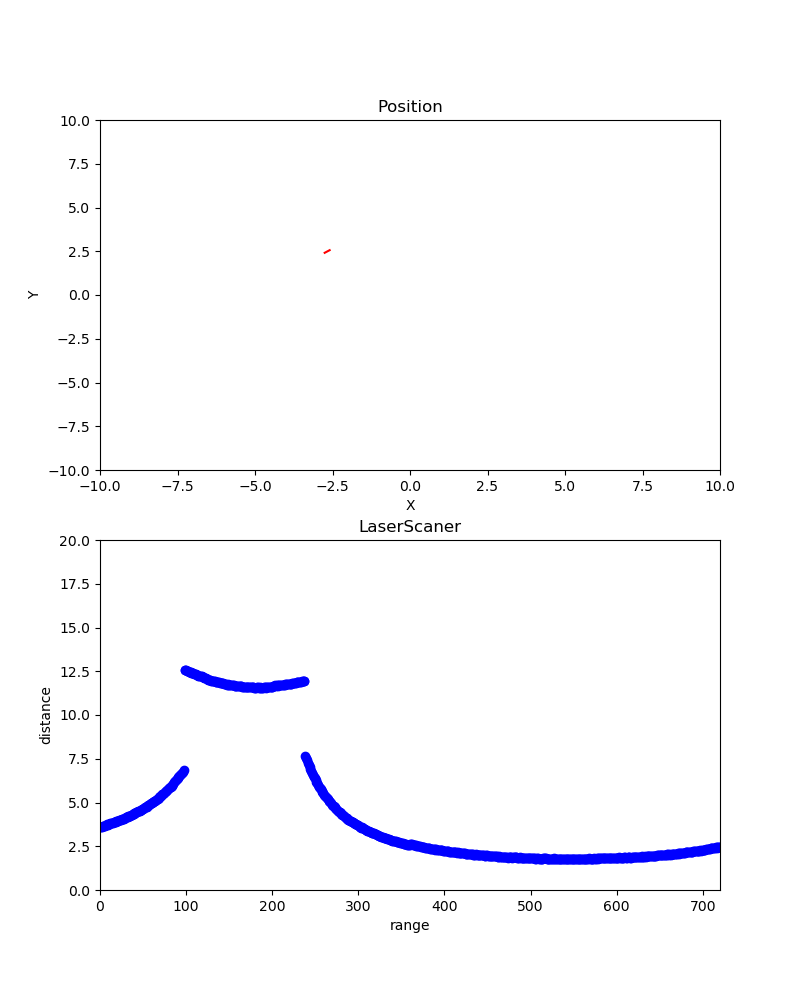

In [23]:
%matplotlib notebook
import matplotlib.pyplot as plt
import tf
from nav_msgs.msg import Odometry
from tf.transformations import quaternion_matrix
from matplotlib.animation import FuncAnimation
from actionlib_msgs.msg import GoalStatusArray

class Visualiser:
    def __init__(self):
        self.fig, self.ax = plt.subplots(2, 1, figsize=(8, 10))  # Adjusted to 2 subplots
        self.ln, = self.ax[0].plot([], [], 'r')
        self.x_dist = []
        self.y_dist = []
        self.ln2, = self.ax[1].plot([], [], 'bo')
        self.x_data = np.linspace(0, 720, 720)
        self.y_data = []
        self.i = 0
        self.j = 0
        self.k1 = 0
        self.k2 = 0

    def plot_init(self):
        self.ax[0].set_xlim(-10, 10)
        self.ax[0].set_ylim(-10, 10)
        self.ax[0].set_title('Position')
        self.ax[0].set_xlabel('X')
        self.ax[0].set_ylabel('Y')
        self.ax[1].set_xlim(0, 720)
        self.ax[1].set_ylim(0, 20)
        self.ax[1].set_title('LaserScaner')
        self.ax[1].set_xlabel('range')
        self.ax[1].set_ylabel('distance')

        return self.ln, self.ln2

    def odom_callback(self, msg):
        self.y_dist.append(msg.pose.pose.position.y)
        self.x_dist.append(msg.pose.pose.position.x)

    def scan_callback(self, msg):
        self.y_data = msg.ranges

    def goal_status_callback(self, msg):
        if len(msg.status_list) != 0:
            if msg.status_list[0].status == 3 and self.k1 == 0:
                self.i += 1
                self.k1 = 1
                self.k2 = 0
            elif msg.status_list[0].status == 4 and self.k2 == 0:
                self.j += 1
                self.k2 = 1
                self.k1 = 0

    def update_plot(self, frame):
        self.ln.set_data(self.x_dist, self.y_dist)
        self.ln2.set_data(self.x_data, self.y_data)
        return self.ln, self.ln2

vis = Visualiser()
sub2 = rospy.Subscriber('/scan', LaserScan, vis.scan_callback)
sub3 = rospy.Subscriber('/move_base/status', GoalStatusArray, vis.goal_status_callback)
sub = rospy.Subscriber('/odom', Odometry, vis.odom_callback)
ani = FuncAnimation(vis.fig, vis.update_plot, init_func=vis.plot_init)
plt.show()  # Add this line to display the graphs


In [24]:
client = actionlib.SimpleActionClient('/reaching_goal', assignment_2_2022.msg.PlanningAction)

#wait for server
client.wait_for_server()

True

In [25]:
jr.subscribe("/reaching_goal/result", assignment_2_2022.msg.PlanningActionResult, checkGoalResult)

Removing previous callback, only one redirection possible right now


In [26]:
def checkGoalResult(msg):
    global r,rn
    
    # Get the status 
    status = msg.status.status

    # If status is 2 the goal is canceled
    if status == 2:
        
        rn = rn + 1

    # If status is 3 the goal is reached
    elif status == 3:
        
        r = r + 1
        print(r)
        
    update_num(r, rn)
    
r, rn = 0,0